In [ ]:
from view import*
from model import *

In [ ]:
if __name__=="__main__":
    data =  [DataModel(channel = 0, dyad = 16, datatype = "eeg") ] #For now SUBJECT TO CHANGE
    video = VideoModel(33,1)
    app = QtGui.QApplication(sys.argv)
    form = MainApp(data, video)
    form.show()
    #form.update() #start with something
    app.exec_()
    print("DONE")

# Finding bug... (#1)
## Video viewer start time matches direct access via videoreader
## Video start time before first frame visible via VLC player (good)
## Timestamp confirms 25 fps

In [2]:
import imageio
import matplotlib.pyplot as plt
video_reader = imageio.get_reader("/data/p_01888/Databook_cleaning/Video/Pilot_33/coSMIC_all_P33_C3.wmv")

In [3]:
import tables

In [4]:
plt.imshow(video_reader.get_data(100)[0:200,0:200])
plt.show()

# Compute ROI mothistmap manually

In [5]:
from database import *
from mot import *

In [6]:
import tables
import numpy as np

In [7]:
db = Database()

In [8]:
db.load_json()

In [9]:
coordinates1 = db.dictionary["33"]["video"]['1']["motion"]["in_roi"]["1"]["coordinates"]
coordinates2 = db.dictionary["33"]["video"]['2']["motion"]["in_roi"]["1"]["coordinates"]
coordinates3 = db.dictionary["33"]["video"]['3']["motion"]["in_roi"]["1"]["coordinates"]
coordinates4 = db.dictionary["33"]["video"]['4']["motion"]["in_roi"]["1"]["coordinates"]

In [10]:
p1 = db.dictionary["33"]["video"]["1"]["motion"]["path"]
p2 = db.dictionary["33"]["video"]["2"]["motion"]["path"]
p3 = db.dictionary["33"]["video"]["3"]["motion"]["path"]
p4 = db.dictionary["33"]["video"]["4"]["motion"]["path"]

In [11]:
vpath1 = db.dictionary["33"]["video"]["1"]["path"]
vpath2 = db.dictionary["33"]["video"]["2"]["path"]
vpath3 = db.dictionary["33"]["video"]["3"]["path"]
vpath4 = db.dictionary["33"]["video"]["4"]["path"]

In [12]:
outpath1 = "/data/pt_01888/motionData/coSMIC_all_P33_C1_V0.roimot"
outpath2 = "/data/pt_01888/motionData/coSMIC_all_P33_C2_V0.roimot"
outpath3 = "/data/pt_01888/motionData/coSMIC_all_P33_C3_V0.roimot"
outpath4 = "/data/pt_01888/motionData/coSMIC_all_P33_C4_V0.roimot"

In [13]:
db.dictionary["33"]["video"]["1"]["motion"]["in_roi"]["1"]["path"] = "/data/pt_01888/motionData/coSMIC_all_P33_C1_V0.roimot"
db.dictionary["33"]["video"]["2"]["motion"]["in_roi"]["1"]["path"] = "/data/pt_01888/motionData/coSMIC_all_P33_C2_V0.roimot"
db.dictionary["33"]["video"]["3"]["motion"]["in_roi"]["1"]["path"] = "/data/pt_01888/motionData/coSMIC_all_P33_C3_V0.roimot"
db.dictionary["33"]["video"]["4"]["motion"]["in_roi"]["1"]["path"] = "/data/pt_01888/motionData/coSMIC_all_P33_C4_V0.roimot"
db.save_as_json()

In [14]:
p = p3
coordinates = coordinates3
vpath = vpath3
outpath = outpath3

In [15]:
c2 = np.array(coordinates)//6

In [16]:
f = tables.open_file(p, mode='r')
d = f.root.data

# Finding bug (#2)
## Video vs. motion: It looks like the video runs slower (more frames)
### Hypothesis: During computation of the .mot files, some frames are not processed
### GUI reveals 14286 frames in motion VS 14318 in video i.e. 32 frames mismatch.

In [17]:
import imageio

In [18]:
import matplotlib.pyplot as plt

In [19]:
video_reader = imageio.get_reader(vpath)

In [20]:
pic = video_reader.get_data(0)
plt.imshow(pic[coordinates[0]:coordinates[2],coordinates[1]:coordinates[3]])
plt.show()

<IPython.core.display.Javascript object>


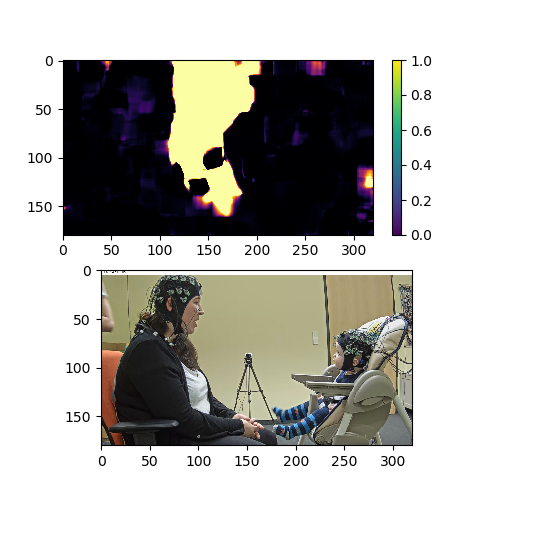

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
 
#plt.ion()
fig = plt.figure(figsize= (5,5))
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(212)


sliced = d[0][int(c2[0]):int(c2[2]),int(c2[1]):int(c2[3])]

U = sliced[:,:,0]
V = sliced[:,:,1]

im = ax.imshow(U+V, vmin = 0, vmax = 1)
plt.colorbar(im,ax=ax)

#prev = video_reader.get_data(0)


for n_frame in range(1,400, 1):
    sliced = d[n_frame+32]#[int(c2[0]):int(c2[2]),int(c2[1]):int(c2[3])]#test 32

    U = sliced[:,:,0]
    V = sliced[:,:,1]
    ax.cla()
    im = ax.imshow(U+V, vmin = 0, vmax = 1, cmap = "inferno")
    
    #Try drawing original pic
    try:
        dataframe = video_reader.get_data(n_frame)
        im2 = ax1.imshow(cv2.resize(dataframe,(320, 180)))
        #assert not np.array_equal(prev, dataframe)
        #prev = dataframe
    except:
        pass
        raise Exception("dead")
    
    #pic = video_reader.get_data(n_frame)
    #ax.imshow(pic[coordinates[0]:coordinates[2],coordinates[1]:coordinates[3]])    
    fig.canvas.draw()
    

In [ ]:
weighted_hist = AnalyzeMotion.compute_weighted_histograms(p,coordinates)

# Tests of parameters and trying to find out reason for mismatch in time

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import cv2

In [35]:
p = db.dictionary["33"]["video"]["3"]["motion"]["path"]
f = tables.open_file(p, mode='r')
d = f.root.data

In [49]:
test_frame = 110

d1 = d[test_frame][:,:,0]
d2 = d[test_frame][:,:,1]
y_comp = cv2.resize(d1, (36,64))
x_comp = cv2.resize(d2, (36,64))


dx = d[test_frame]
ary = np.array([dx[:,:,0].flatten(),dx[:,:,1].flatten()])
deg = np.degrees(np.arctan2(ary[0],ary[1])).reshape(d[0].shape[0:2])
length = np.linalg.norm(ary, axis = 0).reshape(d[0].shape[0:2])

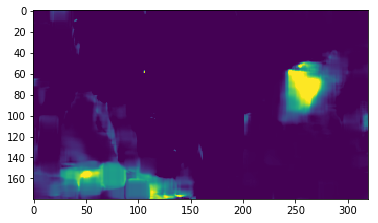

In [50]:
plt.imshow(d1, vmin = 0, vmax = 1)
plt.show()

In [51]:
snippet_length = length[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6]
snippet_deg = deg[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6]

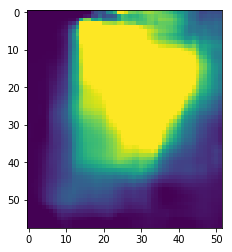

In [52]:
plt.imshow(d1[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6], vmin = 0, vmax = 0.8)
plt.show()

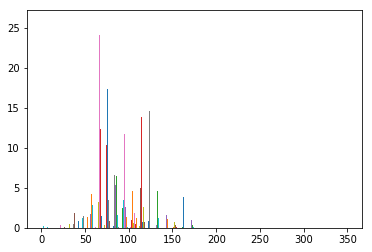

In [53]:
deg_hist= np.histogram(deg[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6])
plt.hist(snippet_deg, weights = np.array(snippet_length), bins = (np.arange(36)*10))
plt.show()

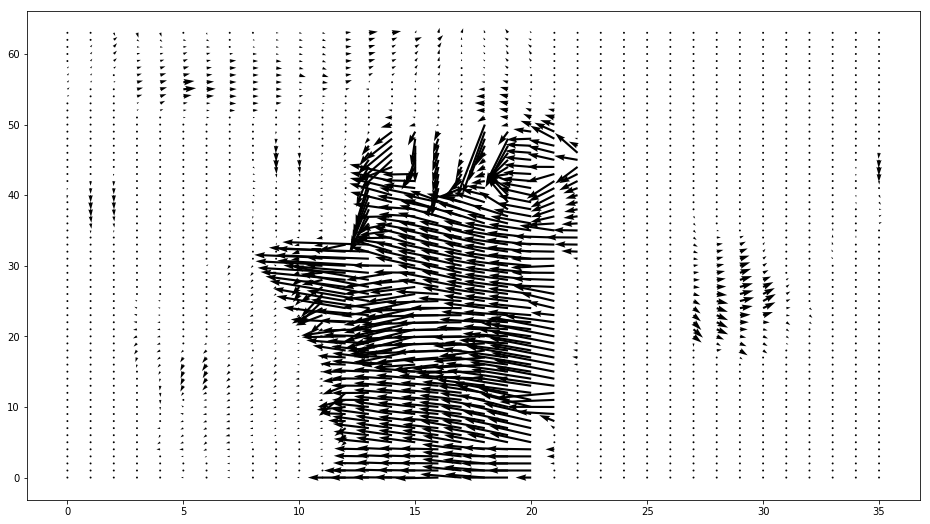

In [54]:
X, Y = np.meshgrid(np.arange(int(36)), np.arange(int(64)))
plt.figure(figsize = (16,9))
Q = plt.quiver(X,Y, y_comp, x_comp)

In [264]:
plt.show()

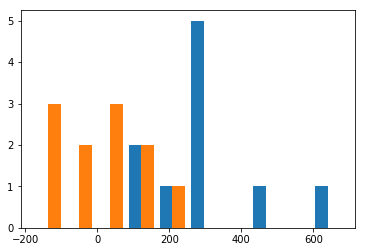

In [265]:
flat_length = np.histogram(length[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6])
flat_deg = np.histogram(deg[coordinates[0]//6:coordinates[2]//6,coordinates[1]//6:coordinates[3]//6])
plt.hist(flat_deg)
plt.show()

In [104]:
flat[1][1:].shape

(10,)

In [84]:
d[0][:,:,0]

(180, 320)

In [18]:
np.array([d1.flatten(),d1.flatten()]).shape

(2, 57600)

In [19]:
def compute_weighted_histograms(data, coordinates):
    coordinates = np.array(coordinates)//6#.mot is 1/6 size as compared to video coordinates

    outary = np.ndarray((400,35))

    for d, i in zip(data, range(400)):
        ary = np.array([d[:,:,0].flatten(),d[:,:,1].flatten()])
        deg = np.degrees(np.arctan2(ary[0],ary[1]))#.reshape(d[0].shape[0:2])
        length = np.linalg.norm(ary, axis = 0)#.reshape(d[0].shape[0:2])
        
        bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180
        weightedHist, bin_edges = np.histogram(deg, weights = length, bins = bins)
        outary[i] = weightedHist
        if i%10 == 0:
            print(".", end = "")
    return outary


In [90]:
#f.close()
f = tables.open_file(p, mode='r')
d = f.root.data

In [91]:
hist = np.array(compute_weighted_histograms(d,coordinates)).T

........................................

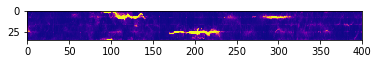

In [191]:
plt.imshow(hist, cmap = "plasma", vmin = 0, vmax = 2500)
plt.show()

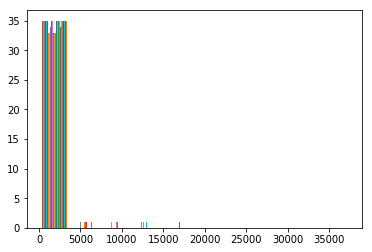

37474.2890625

In [93]:
plt.show(plt.hist(hist))
np.max(hist)

# Inspect histmap and save

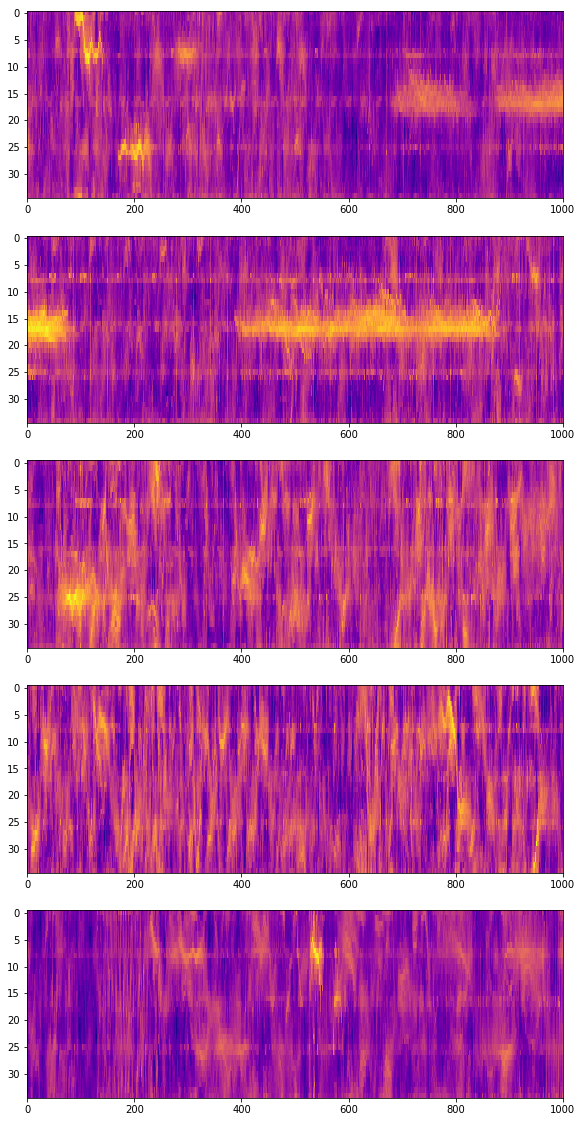

In [33]:
%matplotlib inline
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(511)
ax.imshow(np.log(weighted_hist.T[:,0:1000]),aspect=10, cmap = "plasma")
ax = fig.add_subplot(512)
ax.imshow(np.log(weighted_hist.T[:,1000:2000]),aspect=10, cmap = "plasma")
ax = fig.add_subplot(513)
ax.imshow(np.log(weighted_hist.T[:,2000:3000]),aspect=10, cmap = "plasma")
ax = fig.add_subplot(514)
ax.imshow(np.log(weighted_hist.T[:,4000:5000]),aspect=10, cmap = "plasma")
ax = fig.add_subplot(515)
ax.imshow(np.log(weighted_hist.T[:,6000:7000]),aspect=10, cmap = "plasma")

In [34]:

import tables
print(weighted_hist.shape)

(54286, 35)


In [35]:
shape = [0, weighted_hist.shape[1]]#shape will be 54286 x 35


In [36]:
f.close()
f = tables.open_file(outpath, mode='w')

arr = f.create_earray(f.root, 'data', tables.Float32Atom(), shape)

In [37]:
for x in range(weighted_hist.shape[0]):
    arr.append(np.array([weighted_hist[x,:]]))

In [38]:
arr.shape

(54286, 35)

In [39]:
f.close()

# Additional fun

In [40]:
f = tables.open_file("/data/pt_01888/motionData/coSMIC_all_P33_C1.mot", mode= "r")

In [41]:
f.root.data#should be 54319

/data (EArray(54285, 180, 320, 2)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 102, 320, 2)

In [42]:
import matplotlib.pyplot as plt


In [43]:
f = tables.open_file(outpath, mode='r')
d = f.root.data

In [44]:
db.save_as_json()

In [45]:
db.dictionary["33"]["motion"]["3"]["in_roi"]["1"]["path"]

KeyError: 'motion'

In [30]:
dispStrength[y][x] = np.linalg.norm(flow[y][x]) #equivalent to sqrt(a^2+b^2)
#dispDir[y][x] = np.degrees(np.arctan2(flow[y][x][0],flow[y][x][1])) #returns direction of vector

NameError: name 'flow' is not defined

In [31]:
x_component, y_component = AnalyzeMotion.compute_roi_motion(p,coordinates)
plt.plot(x_component)
plt.show()

0.0
0.00184209556792
0.00368419113584
0.00552628670375
0.00736838227167
0.00921047783959
0.0110525734075
0.0128946689754
0.0147367645433
0.0165788601113
0.0184209556792
0.0202630512471


KeyboardInterrupt: 

In [ ]:
Database.search_key(db.dictionary, "in_roi")